In [19]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
import re
from typing import Callable
import seaborn as sns

In [20]:
# fe = fm.FontEntry(
#     fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # ttf 파일이 저장되어 있는 경로
#     name='NanumBarunGothic')  # 이 폰트의 원하는 이름 설정
# fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
# plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'})  # 폰트 설정
# plt.rc('font', family='NanumBarunGothic')

# mac os
fe = fm.FontEntry(
    fname=r'/System/Library/Fonts/Supplemental/AppleGothic.ttf',  # ttf 파일이 저장되어 있는 경로
    name='AppleGothic')  # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'AppleGothic'})  # 폰트 설정
plt.rc('font', family='AppleGothic')

In [21]:
house = pd.read_csv('../02_data_process/house_select.csv')

/var/folders/h2/3s0kf71j1wd60qyytwysjfl40000gn/T/ipykernel_7135/658595238.py:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  house = pd.read_csv('../02_data_process/house_select.csv')


In [22]:
house['계약연도'].unique()

array([2017, 2018, 2011, 2012, 2023])

In [23]:
house = house[(house['is_test'] == 1) | ((house['is_test'] == 0) & (house['계약연도'].isin([2018, 2023])))]

In [24]:
house[(house['is_test']==1)].shape

(9272, 68)

In [25]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in house.columns:
    if pd.api.types.is_numeric_dtype(house[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['본번', '부번', '전용면적', '계약년월', '계약일', '층', '건축년도', 'k_전체동수', 'k_전체세대수', 'k_연면적', 'k_주거전용면적', 'k_관리비부과면적', 'k_전용면적별세대현황_60㎡이하_', 'k_전용면적별세대현황_60㎡~85㎡이하_', 'k_85㎡~135㎡이하', 'target', 'is_test', '경도', '위도', '1_bus', '3_bus', '5_bus', '10_bus', '1_school', '3_school', '5_school', '10_school', 'bus_access_score', 'sub_access_score', 'school_access_score', '1_sub', '3_sub', '5_sub', '10_sub', '계약연도', '계약월', '아파트_최고층', '층_최고층대비비율', '구_해당달_거래수', '동_해당달_거래수', '구_직전달까지누적거래수', '동_직전달까지누적거래수', '동대구_해당달_비율', '동대구_직전누적_비율', '연식', '강남여부', '브랜드']
범주형 변수: ['아파트명', '도로명', 'k_단지분류_아파트_주상복합등등_', 'k_전화번호', 'k_팩스번호', 'k_세대타입_분양형태_', 'k_관리방식', 'k_복도유형', 'k_난방방식', 'k_건설사_시공사_', 'k_시행사', 'k_사용검사일-사용승인일', 'k_수정일자', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '주소', '구', '동', '층구간_상대', '연식_bin']


In [26]:
# 범주형 변수에 대한 보간
house[categorical_columns] = house[categorical_columns].fillna('NULL')

In [27]:
house.isnull().sum()

본번             15
부번             15
아파트명            0
전용면적            0
계약년월            0
               ..
동대구_직전누적_비율     0
연식              0
연식_bin          0
강남여부            0
브랜드             0
Length: 68, dtype: int64

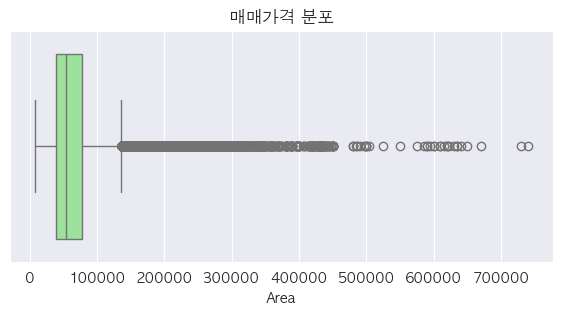

In [28]:
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = house, x = 'target', color='lightgreen')
plt.title('매매가격 분포')
plt.xlabel('Area')
plt.show()


In [29]:
# IQR 기준으로 '전용면적' 이상치 값 확인
col = 'target'
s = house[col].dropna()

q1 = s.quantile(0.25)
q3 = s.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

mask_outlier = (house[col] < lower) | (house[col] > upper)
out_vals = house.loc[mask_outlier, col]

print(f"[IQR 기준 임계값] lower={lower:.3f}, upper={upper:.3f}")
print(f"[이상치 개수] {mask_outlier.sum()} / {len(house)} (비율 {mask_outlier.mean():.2%})")

# 이상치 값들(중복 제거) 정렬
uniq_vals = np.sort(out_vals.unique())

# 너무 많을 수 있으니 하위/상위 일부만 미리보기
n_show = 20
print("\n[하위 쪽 이상치 값 미리보기]")
print(uniq_vals[:n_show])

print("\n[상위 쪽 이상치 값 미리보기]")
print(uniq_vals[-n_show:])

# 빈도 상위 값 확인(어떤 값들이 자주 등장하는지)
print("\n[이상치 값 상위 빈도]")
print(out_vals.value_counts().head(15))

# 이상치 행 몇 개 확인(필요 시 다른 컬럼도 함께 보세요)
print("\n[이상치 행 미리보기]")
display(house.loc[mask_outlier].sort_values(col).head(10))

[IQR 기준 임계값] lower=-20500.000, upper=136300.000
[이상치 개수] 5530 / 83211 (비율 6.65%)

[하위 쪽 이상치 값 미리보기]
[136500. 136800. 136900. 137000. 137250. 137281. 137300. 137400. 137500.
 137650. 137700. 137800. 138000. 138100. 138300. 138500. 138880. 139000.
 139200. 139300.]

[상위 쪽 이상치 값 미리보기]
[504000. 525000. 550000. 575000. 585000. 590000. 595000. 600000. 610000.
 615000. 620000. 623000. 630000. 634000. 635000. 640000. 650000. 670000.
 730000. 740000.]

[이상치 값 상위 빈도]
target
150000.0    238
140000.0    234
160000.0    198
145000.0    151
170000.0    141
155000.0    122
165000.0    115
200000.0     95
175000.0     91
180000.0     91
190000.0     78
210000.0     77
138000.0     72
185000.0     69
220000.0     63
Name: count, dtype: int64

[이상치 행 미리보기]


,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,k_단지분류_아파트_주상복합등등_,...,구_해당달_거래수,동_해당달_거래수,구_직전달까지누적거래수,동_직전달까지누적거래수,동대구_해당달_비율,동대구_직전누적_비율,연식,연식_bin,강남여부,브랜드
74144,17.0,0.0,파크리오,84.9000,201808,11,17,2008,올림픽로 435,NULL,...,941,118,4636,58,0.125399,0.012511,10,준신축_10년,1,False
77389,902.0,0.0,목동신시가지2,95.7600,201801,29,2,1986,목동서로 70,NULL,...,538,186,544,16,0.345725,0.029412,32,노후_20년초과,0,False
63985,1066.0,0.0,텐즈힐,148.8000,201802,8,15,2015,무학로 33,NULL,...,345,51,1493,1,0.147826,0.000670,3,신축_5년,0,False
623,527.0,0.0,도곡렉슬,59.9772,201808,13,17,2006,선릉로 221,아파트,...,725,140,2038,74,0.193103,0.036310,12,중고_20년,1,True
78311,961.0,0.0,하이페리온2,136.0810,201801,9,12,2006,오목로 300,NULL,...,538,186,544,16,0.345725,0.029412,12,중고_20년,0,False
75831,35.0,0.0,트리지움,84.9700,201801,5,17,2007,잠실로 62,NULL,...,988,180,438,30,0.182186,0.068493,11,중고_20년,1,False
74046,17.0,0.0,파크리오,84.7900,201801,20,18,2008,올림픽로 435,NULL,...,988,111,438,42,0.112348,0.095890,10,준신축_10년,1,False
71543,150.0,0.0,올림픽훼밀리타운,84.7510,201809,8,2,1988,중대로 24,아파트,...,537,71,4098,166,0.132216,0.040508,30,노후_20년초과,1,True
63011,377.0,0.0,서울숲더샵,114.4000,201809,14,38,2014,왕십리로 241,주상복합,...,294,66,3588,934,0.224490,0.260312,4,신축_5년,0,True
2563,463.0,1.0,우성사원5,78.9900,201802,7,8,1986,언주로29길 34,NULL,...,354,65,4582,131,0.183616,0.028590,32,노후_20년초과,1,False


In [30]:
region_col = '구'          # 지역
area_col   = '전용면적'     # 면적
target_col = 'target'      # 타깃

df = house.copy()

# 분리
df_train = df[df['is_test'] == 0].copy()
df_test  = df[df['is_test'] == 1].copy()

# 1) 타깃 로그 변환(Train만)
df_train['target_log'] = np.log1p(df_train[target_col])

# 2) 지역 내 면적 분위수 기반 버킷 경계(Train에서만) 생성 → 전체에 적용
n_bins = 10  # 표본 적으면 5로 조정 권장
quant_grid = np.linspace(0.0, 1.0, n_bins + 1)

# 지역별 면적 분위수 경계 사전: {region: np.ndarray(edges)}
edges_by_region = {}
global_edges = np.quantile(df_train[area_col].values, quant_grid)
global_edges = np.unique(global_edges)  # 중복 제거(동일값 다수일 때 대비)

for region, g in df_train.groupby(region_col, observed=True, dropna=False):
    edges = np.quantile(g[area_col].values, quant_grid) if len(g) > 0 else global_edges
    edges = np.unique(edges)
    # 유효한 경계가 최소 2개 미만이면 글로벌 경계 사용
    if edges.size < 2:
        edges = global_edges
    edges_by_region[region] = edges

def assign_area_bin(row):
    region = row[region_col]
    val = row[area_col]
    edges = edges_by_region.get(region, global_edges)
    # pd.cut은 경계가 2개 이상 필요
    if edges.size < 2 or pd.isna(val):
        return pd.NA
    try:
        return pd.cut([val], bins=edges, labels=False, include_lowest=True)[0]
    except Exception:
        # 값이 경계를 벗어나거나, 경계 중복 등 문제 시 약간의 확장으로 재시도
        span = edges[-1] - edges[0] if edges.size >= 2 else 1.0
        eps = span * 1e-6 if span > 0 else 1e-6
        edges_safe = edges.copy()
        edges_safe[0]  = edges_safe[0] - eps
        edges_safe[-1] = edges_safe[-1] + eps
        try:
            return pd.cut([val], bins=edges_safe, labels=False, include_lowest=True)[0]
        except Exception:
            return pd.NA

df['area_bin_in_region'] = df.apply(assign_area_bin, axis=1).astype('Int64')

# 3) 로그 스케일에서 지역×면적버킷별 하/상위 분위수 계산(Train만)
low_q, up_q = 0.005, 0.995  # 0.5% ~ 99.5%
grp = (
    df_train
    .merge(df[['area_bin_in_region']], left_index=True, right_index=True)
    .groupby([region_col, 'area_bin_in_region'], observed=True, dropna=False)['target_log']
)
q_df = grp.quantile([low_q, up_q]).unstack(level=-1)
q_df.columns = ['log_low', 'log_up']

# 4) 각 행에 임계값 매핑 + 결측(표본 부족 그룹)은 Train 전역 분위수로 보완
df_all = df.copy()
df_all = df_all.merge(q_df, left_on=[region_col, 'area_bin_in_region'], right_index=True, how='left')

global_low = df_train['target_log'].quantile(low_q)
global_up  = df_train['target_log'].quantile(up_q)
df_all['log_low'] = df_all['log_low'].fillna(global_low)
df_all['log_up']  = df_all['log_up'].fillna(global_up)

# 5) 클리핑(윈저라이징) - Train만 적용
df_all['target_log'] = np.where(df_all['is_test'] == 0, np.log1p(df_all[target_col]), np.nan)
df_all['target_log_clip'] = df_all['target_log']  # 기본값

mask_train = df_all['is_test'] == 0
df_all.loc[mask_train, 'target_log_clip'] = df_all.loc[mask_train, 'target_log'].clip(
    lower=df_all.loc[mask_train, 'log_low'],
    upper=df_all.loc[mask_train, 'log_up']
)
df_all['target_clip'] = np.expm1(df_all['target_log_clip'])

# 6) 모니터링(Train 기준)
clipped_low  = (df_all['target_log'] < df_all['log_low']) & mask_train
clipped_high = (df_all['target_log'] > df_all['log_up']) & mask_train
clipped_any  = clipped_low | clipped_high
print(f"[클리핑 비율 - Train] 전체={clipped_any.mean():.2%} / 하위={clipped_low.mean():.2%} / 상위={clipped_high.mean():.2%}")

# 7) 결과를 원본 house에 반영
house['area_bin_in_region'] = df_all['area_bin_in_region'].values
# Train만 존재하는 타깃 파생치
house.loc[mask_train, 'target_log_clip'] = df_all.loc[mask_train, 'target_log_clip'].values
house.loc[mask_train, 'target_clip']     = df_all.loc[mask_train, 'target_clip'].values

[클리핑 비율 - Train] 전체=1.09% / 하위=0.55% / 상위=0.54%


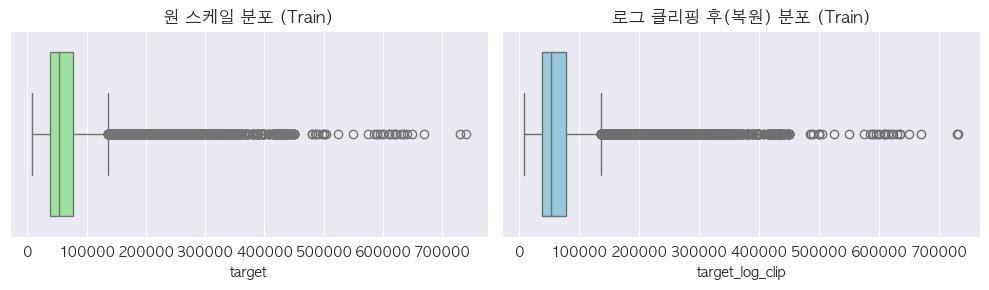

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.boxplot(x=df_train[target_col], color='lightgreen', ax=axes[0])
axes[0].set_title('원 스케일 분포 (Train)')

sns.boxplot(x=np.expm1(df_all.loc[mask_train, 'target_log_clip']), color='skyblue', ax=axes[1])
axes[1].set_title('로그 클리핑 후(복원) 분포 (Train)')
plt.tight_layout()
plt.show()

# 튜닝 필요 시
# - 상단 꼬리가 여전히 길어 모델이 고가 추정에 어려움이 있으면 상한 분위수를 조금 더 낮춰보세요.
#     - 예: 0.5–99.0% 또는 1.0–99.0%
#
# - 반대로 고가 구간 예측력이 떨어진다면 상한을 살짝 완화.
#     - 예: 0.25–99.75% (표본이 충분한 그룹에 한해)


In [32]:
# house.columns 기반으로 feature 컬럼 자동 선택(타깃 관련은 제외)
exclude_target_cols = ['target_log_clip', 'target_clip', 'target']
feature_cols = [c for c in house.columns if c not in exclude_target_cols]

# Train/Test 분리 후 저장: Train에는 target_log_clip만 포함
train_out = house[house['is_test'] == 0][feature_cols + ['target_log_clip']]
test_out  = house[house['is_test'] == 1][feature_cols]

print(f"[INFO] 결측치 제거 전 train shape: {train_out.shape}")
train_out = train_out[train_out['target_log_clip'].notna()]
print(f"[INFO] 결측치 제거 후 train shape: {train_out.shape}")

train_out.to_csv('train_processed.csv', index=False)
test_out.to_csv('test_processed.csv', index=False)
print('Saved: train_processed.csv, test_processed.csv')


[INFO] 결측치 제거 전 train shape: (73939, 69)
[INFO] 결측치 제거 후 train shape: (73939, 69)
Saved: train_processed.csv, test_processed.csv
